In [2]:
import pyproj
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from shapely.ops import nearest_points
from shapely.geometry import Point
import osmnx as ox
import json
import os

ROOT_FILES = 'C:/Users/Linus/PycharmProjects/BA/'
ROOT_Busstations = 'src/main/resources/Buslinie/Busstationen/'

#Pfad zur Shapefile-Datei mit den Strassen
ROOT_RESOURCE_STRASSENNETZ = 'src/main/resources/QGIS/Strassen/'

# Minimale und maximale Breite und Länge des Rechtecks
north, south, east, west = 47.3876, 47.2521, 8.754, 8.6003

# Herunterladen des Straßennetzwerks basierend auf dem Rechteck
G = ox.graph.graph_from_bbox(north, south, east, west, network_type='drive')

# Konvertieren des Graphen in ein GeoJSON-FeatureCollection
features = ox.graph_to_gdfs(G, nodes=False, edges=True)
geojson_data = features.to_json()

# Bestimmen des relativen Pfads
file_path = ROOT_FILES + ROOT_RESOURCE_STRASSENNETZ + "strassenetzwerk.geojson"

# Schreiben des GeoJSON-Daten in die Datei
with open(file_path, "w") as f:
    json.dump(geojson_data, f)

# impute edge (driving) speeds and calculate edge travel times
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

# you can convert MultiDiGraph to/from GeoPandas GeoDataFrames
print(type(G))
gdf_nodes, gdf_edges = ox.utils_graph.graph_to_gdfs(G)
G = ox.utils_graph.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)


<class 'networkx.classes.multidigraph.MultiDiGraph'>


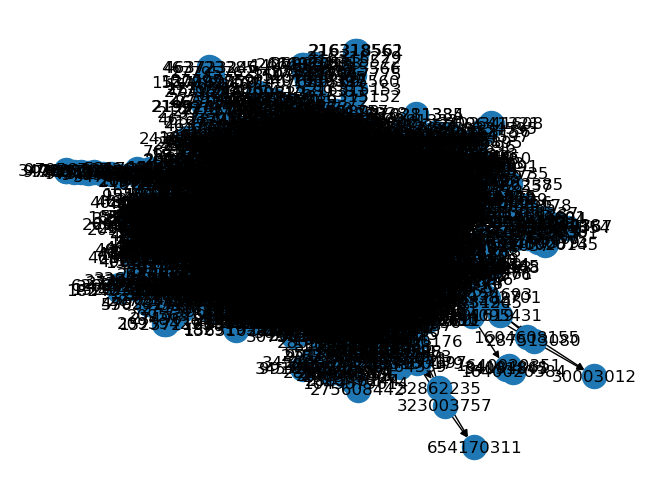

In [3]:
# Zeichne den Graphen
nx.draw(G, with_labels=True)

# Zeige den Graphen an
plt.show()

<class 'networkx.classes.multidigraph.MultiDiGraph'>


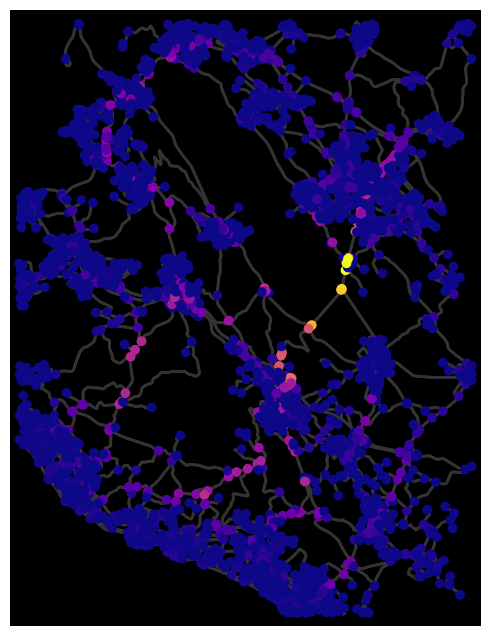

In [4]:
# impute edge (driving) speeds and calculate edge travel times
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

# you can convert MultiDiGraph to/from GeoPandas GeoDataFrames
print(type(G))
gdf_nodes, gdf_edges = ox.utils_graph.graph_to_gdfs(G)
G = ox.utils_graph.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

# convert MultiDiGraph to DiGraph to use nx.betweenness_centrality function
# choose between parallel edges by minimizing travel_time attribute value
D = ox.utils_graph.get_digraph(G, weight="travel_time")

# calculate node betweenness centrality, weighted by travel time
bc = nx.betweenness_centrality(D, weight="travel_time", normalized=True)
nx.set_node_attributes(G, values=bc, name="bc")

# plot the graph, coloring nodes by betweenness centrality
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")
fig, ax = ox.plot.plot_graph(
    G, bgcolor="k", node_color=nc, node_size=50, edge_linewidth=2, edge_color="#333333")

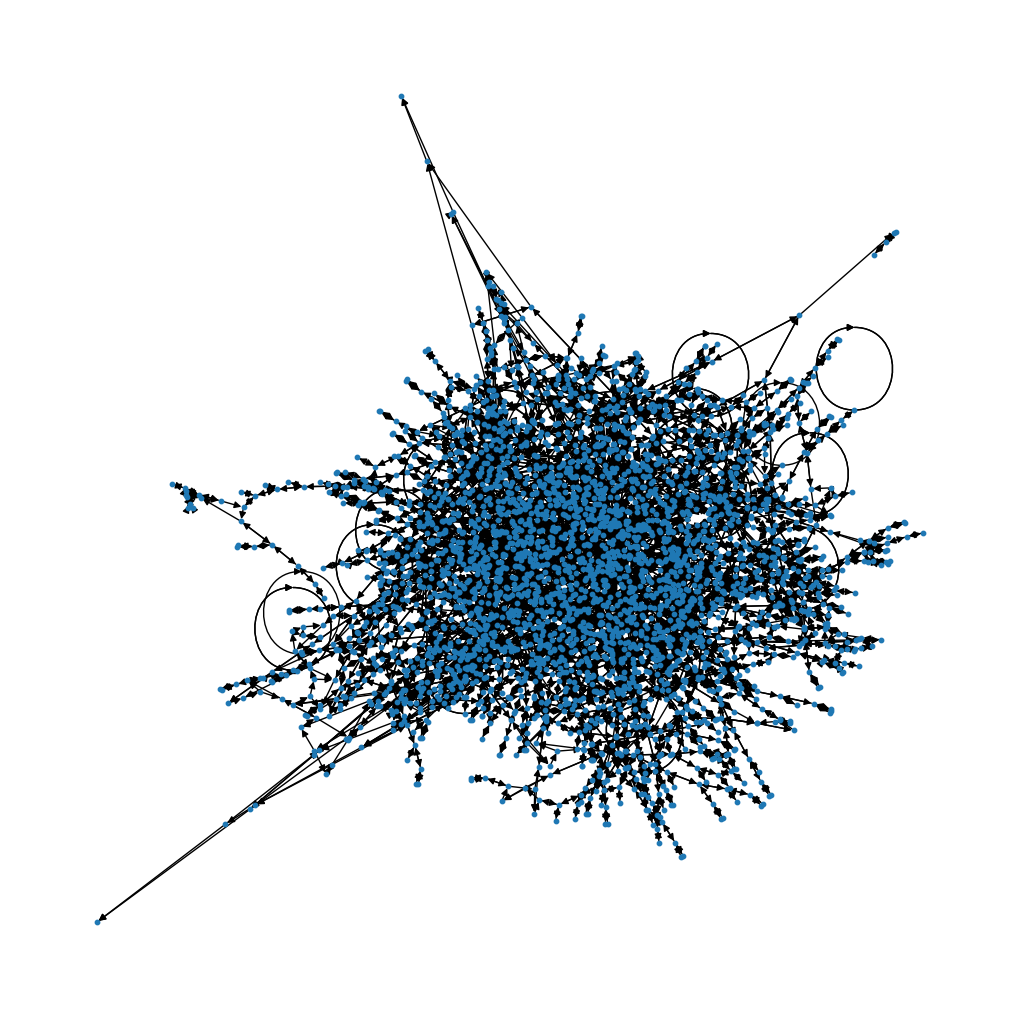

In [5]:
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=False, node_size=10)
plt.show()

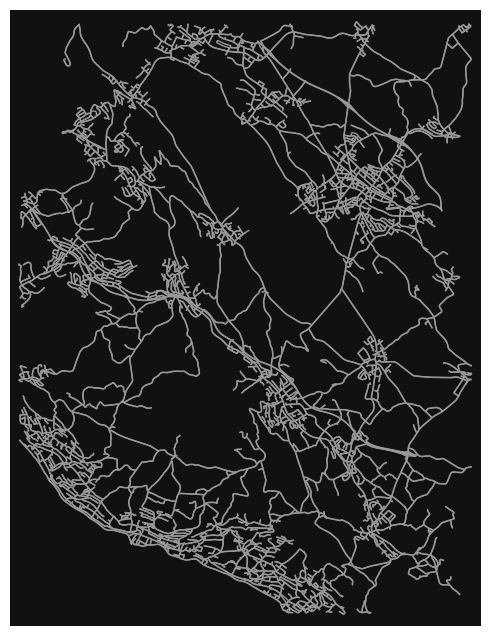

In [6]:
fig, ax = ox.plot_graph(G, node_size=0)

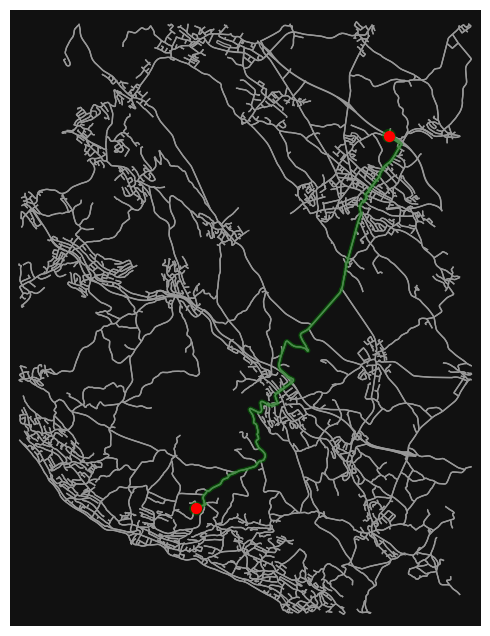

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [7]:
# Plot des Straßennetzwerks mit markierter Node
fig, ax = ox.plot_graph(G, node_size=0, show=False)
# Markiere die ausgewählte Node
2503945255 and 317980720
node_id1 = 317980720  # Node ID
node_position1 = G.nodes[node_id1]['x'], G.nodes[node_id1]['y']  # Koordinaten der Node
ax.scatter(*node_position1, color='red', s=50, zorder=5)
node_id2 = 2503945255  # Node ID
node_position2 = G.nodes[node_id2]['x'], G.nodes[node_id2]['y']  # Koordinaten der Node
ax.scatter(*node_position2, color='red', s=50, zorder=5)

# Berechnen des kürzesten Pfads zwischen den ausgewählten Nodes
shortest_path = nx.shortest_path(G, node_id1, node_id2, weight="length")

# Plot des kürzesten Pfads
ox.plot_graph_route(G, shortest_path, route_color='green', route_linewidth=3, node_size=0, ax=ax, show=True)


In [8]:
ROOT_FILES = 'C:/Users/Linus/PycharmProjects/BA/'
ROOT_ODPT_stops = 'src/main/resources/ODPT/'

#Pfad zur Shapefile-Datei mit den Strassen
ROOT_RESOURCE_STRASSENNETZ = 'src/main/resources/QGIS/Strassen/'
#DATEN_STRASSENNETZ = gpd.read_file(ROOT_FILES + ROOT_RESOURCE_STRASSENNETZ + 'Tramstrasse.shp')

# save graph as a geopackage or graphml file
#ox.io.save_graph_geopackage(G, filepath = ROOT_FILES + ROOT_RESOURCE_STRASSENNETZ + "./OSMStrassennetz.gpkg")

# Pfad zur Shapefile-Datei mit den Bushaltestellen
shapefile_path = ROOT_FILES + ROOT_ODPT_stops + "ODPTSTOPS.shp"

# Laden der Bushaltestellen als GeoDataFrame
ODPT_stops = gpd.read_file(shapefile_path)

print(ODPT_stops)

def add_return_trip(ODPT_stops):
    # Kopiere das GeoDataFrame, um die Rückfahrt-Haltestellen hinzuzufügen
    return_trip_stops = ODPT_stops.copy()

    # Entferne die Haltestelle mit der niedrigsten und höchsten ID
    return_trip_stops = return_trip_stops.iloc[:-1]

    # Kehre die Reihenfolge der Haltestellen um
    return_trip_stops = return_trip_stops.iloc[::-1]

    # Füge die Rückfahrt-Haltestellen hinzu
    ODPT_stops_with_return = pd.concat([ODPT_stops, return_trip_stops], ignore_index=True)
    
    return ODPT_stops_with_return

# Beispielaufruf
ODPT_stops_with_return = add_return_trip(ODPT_stops)


print(ODPT_stops_with_return)

   id    name                         geometry
0   1  Meilen  POINT (2691216.542 1236096.946)
1   2     Egg  POINT (2694601.091 1239702.123)
2   3   Uster  POINT (2696622.343 1245221.347)
   id    name                         geometry
0   1  Meilen  POINT (2691216.542 1236096.946)
1   2     Egg  POINT (2694601.091 1239702.123)
2   3   Uster  POINT (2696622.343 1245221.347)
3   2     Egg  POINT (2694601.091 1239702.123)
4   1  Meilen  POINT (2691216.542 1236096.946)


In [9]:
def load_geojson(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

# Beispielaufruf der Funktion
ROOT_DOCS = 'src/main/resources/Dokumente/'
file_path = ROOT_FILES + ROOT_DOCS + "Nachfrage.geojson"
demand_geojson = load_geojson(file_path)
file_path = ROOT_FILES + ROOT_DOCS + "Ziele.geojson"
destination_geojson = load_geojson(file_path)
print(demand_geojson)
print(type(demand_geojson))


{'type': 'FeatureCollection', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::2056'}}, 'features': [{'type': 'Feature', 'properties': {'timestamp': '2018-04-21T04:12:29', 'gemeinde': 'Egg', 'passagier_nummer': 1}, 'geometry': {'type': 'Point', 'coordinates': [2694615.7931088475, 1239723.5898739498]}}, {'type': 'Feature', 'properties': {'timestamp': '2018-04-20T17:04:04', 'gemeinde': 'Egg', 'passagier_nummer': 2}, 'geometry': {'type': 'Point', 'coordinates': [2694044.5500049773, 1240145.8370785029]}}, {'type': 'Feature', 'properties': {'timestamp': '2018-04-20T16:57:45', 'gemeinde': 'Egg', 'passagier_nummer': 3}, 'geometry': {'type': 'Point', 'coordinates': [2694929.450672205, 1239984.8066820996]}}, {'type': 'Feature', 'properties': {'timestamp': '2018-04-21T07:26:36', 'gemeinde': 'Egg', 'passagier_nummer': 4}, 'geometry': {'type': 'Point', 'coordinates': [2694560.9397718534, 1239509.1941757742]}}, {'type': 'Feature', 'properties': {'timestamp': '2018-04-21T01:47:2

In [10]:
import networkx as nx
import geopandas as gpd

# LV95 Projektionsdefinition
lv95 = pyproj.Proj(init='epsg:2056')

# WGS 84 Projektionsdefinition
wgs84 = pyproj.Proj(init='epsg:4326')

ODPT_stops_with_return_wgs84 = ODPT_stops_with_return.copy()

# Funktion zur Umwandlung von LV95 nach WGS 84
def lv95_to_wgs84(point):
    x_lv95, y_lv95 = point.x, point.y
    x_wgs84, y_wgs84 = pyproj.transform(lv95, wgs84, x_lv95, y_lv95)
    return Point(x_wgs84, y_wgs84)

# Beispiel GeoDataFrame
# Annahme: MeinGDF ist Ihr GeoDataFrame
# Annahme: Die Geometrie ist vom Typ Point
ODPT_stops_with_return_wgs84['geometry'] = ODPT_stops_with_return_wgs84['geometry'].apply(lv95_to_wgs84)

# Ergebnis: MeinGDF enthält nun die Geometrien im WGS 84 Format
#print(ODPT_stops_with_return_wgs84)

ROOT_DOCS = 'src/main/resources/Dokumente/'
demand_file_path = ROOT_FILES + ROOT_DOCS + "Nachfrage.geojson"
target_file_path = ROOT_FILES + ROOT_DOCS + "Ziele.geojson"
demand_gdf = gpd.read_file(demand_file_path)
demand_gdf_wgs84 = demand_gdf.copy()
target_gdf = gpd.read_file(target_file_path)
target_gdf_wgs84 = target_gdf.copy()

demand_gdf_wgs84['geometry'] = demand_gdf_wgs84['geometry'].apply(lv95_to_wgs84)
target_gdf_wgs84['geometry'] = target_gdf_wgs84['geometry'].apply(lv95_to_wgs84)
#print(demand_gdf_wgs84)
#print(target_gdf_wgs84)
print(ODPT_stops_with_return_wgs84)

c:\Users\Linus\anaconda3\envs\gta23v2\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\Linus\anaconda3\envs\gta23v2\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\Linus\AppData\Local\Temp\ipykernel_15600\3641909624.py:15: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-fr

   id    name              geometry
0   1  Meilen  POINT (8.644 47.269)
1   2     Egg  POINT (8.690 47.301)
2   3   Uster  POINT (8.717 47.351)
3   2     Egg  POINT (8.690 47.301)
4   1  Meilen  POINT (8.644 47.269)


In [11]:
print(target_gdf_wgs84)

   gemeinde  passagier_nummer                  geometry
0     Uster                 1  POINT (8.72425 47.36062)
1    Meilen                 2  POINT (8.66657 47.26279)
2     Uster                 3  POINT (8.74535 47.36177)
3    Meilen                 4  POINT (8.66020 47.26495)
4    Meilen                 5  POINT (8.63957 47.27341)
5    Meilen                 6  POINT (8.66657 47.26279)
6    Meilen                 7  POINT (8.62313 47.27716)
7    Meilen                 8  POINT (8.62189 47.27573)
8     Uster                 9  POINT (8.69291 47.35056)
9     Uster                10  POINT (8.74583 47.36091)
10    Uster                11  POINT (8.72651 47.34080)
11    Uster                12  POINT (8.70792 47.35155)
12    Uster                13  POINT (8.68907 47.36956)
13    Uster                14  POINT (8.74507 47.36273)
14    Uster                15  POINT (8.70304 47.34350)
15    Uster                16  POINT (8.73359 47.37490)
16      Egg                17  POINT (8.68952 47

In [12]:
def get_nearest_node(G, point):
    nearest_node = ox.distance.nearest_nodes(G, point.x, point.y)
    return nearest_node

def preprocess_gdfs(demand_gdf, target_gdf, main_stops_gdf, graph):
    # Vorverarbeiten der GeoDataFrames, um die Nodes auf dem Straßennetz zu erhalten
    demand_nodes = [get_nearest_node(graph, point) for point in demand_gdf.geometry]
    target_nodes = [get_nearest_node(graph, point) for point in target_gdf.geometry]
    main_stop_nodes = [get_nearest_node(graph, point) for point in main_stops_gdf.geometry] 
    return demand_nodes, target_nodes, main_stop_nodes

demand_nodes, target_nodes, main_stop_nodes = preprocess_gdfs(demand_gdf_wgs84, target_gdf_wgs84, ODPT_stops_with_return_wgs84, G)
print(demand_nodes)
print(target_nodes)
print(main_stop_nodes)
print(type(main_stop_nodes))

[393962506, 225070486, 1599382701, 35831131, 225060342, 264890212, 1493170958, 3339504718, 216315152, 264890379, 469836453, 264890379, 225060571, 238482572, 1774614125, 35831136, 293032863, 1251070885, 274987141, 269549823, 207721781, 317980720, 470239711, 274987141, 320177238, 105347427, 132758550, 267951857, 130042898, 1990981171, 207719272, 267945862, 269423010, 1644843251, 331865765, 218332079, 463491890, 216514633]
[317980720, 1605601293, 300054901, 6476376862, 2503841517, 1605601293, 331865765, 1610983126, 132710300, 307501801, 63525469, 252598832, 316654394, 207721781, 320151389, 207719174, 1493171026, 225070486, 1509996896, 35831131, 1493171026, 264890212, 1493171026, 1509996865, 225060571, 3339463694, 1880125007, 469243808, 470209671, 393952770, 216315560, 225062017, 10307592895, 207718470, 318136827, 1479539522, 243093454, 2153072108]
[66861087, 393962506, 627939873, 393962506, 66861087]
<class 'list'>


In [13]:
def process_demand_points(demand_gdf, demand_nodes, target_gdf, target_nodes, main_stops_gdf, main_stop_nodes, graph):    
    # Initialisiere Zähler für erfolgreiche Fahrten
    successful_trips = 0
    
    # Finde den Hauptpunkt mit der niedrigsten ID
    source_point = main_stops_gdf.loc[main_stops_gdf['id'].idxmin()]
    print('Source Punkt:', source_point)

    # Iteriere durch jeden Nachfragepunkt
    for demand_node in demand_nodes:
        # Finde den nächsten Punkt im Straßennetzwerk zum Nachfragepunkt
        #nearest_point = find_nearest_point(graph, demand_node)
        #print('Nächster Punkt', nearest_point)

        # Index des aktuellen Abschnittes
        index_section = 0
        # Start und Zielpunkt des aktuellen Abschnittes in der Liste der Main-Stops
        main_stop = main_stop_nodes[index_section]
        next_main_stop = main_stop_nodes[index_section + 1]
        
        # Berechne die Zeit bis zum nächsten Punkt
        travel_time_to_nearest = calculate_travel_time(graph, main_stop, demand_node)
        print('Zeit zum nächsten Punkt:' , travel_time_to_nearest)
        
        # Finde Zielpunkt basierend auf Demand-Knoten
        target_node = target_nodes[demand_nodes.index(demand_node)]
        print('Zielpunkt:', target_node)
        
        # Überprüfe, ob der Zielpunkt näher am nächsten Main-Stop liegt als am aktuellen
        if nx.shortest_path_length(graph, demand_node, next_main_stop) < nx.shortest_path_length(graph, demand_node, target_node):
            target_node = next_main_stop
        
        # Berechne die Zeit zum Ziel
        travel_time_to_target = calculate_travel_time(graph, demand_node, target_node)
        print('Zeit zum Ziel:', travel_time_to_target)
        
        # Überprüfe, ob die Gesamtzeit unter 15 Minuten liegt
        total_travel_time = travel_time_to_nearest + travel_time_to_target
        if total_travel_time < 900:
            # Lade Punkt in neues GeoDataFrame
            # Erhöhe den Zähler für erfolgreiche Fahrten
            successful_trips += 1
    
    return successful_trips

# Hilfsfunktionen

# Definieren Sie eine Funktion, um die nächsten Netzwerkknoten zu einem Punkt zu finden
def get_nearest_node(G, point):
    nearest_node = ox.distance.nearest_nodes(G, point.x, point.y)
    return nearest_node

def find_nearest_point(graph, point):
    # Finde den nächsten Punkt im Straßennetzwerk zum gegebenen Punkt
    nearest_node = get_nearest_node(graph, point)
    return nearest_node

def calculate_travel_time(G, source, target_node):
    # Finde die nächsten Netzwerkknoten zu den Quell- und Zielknoten
    #nearest_source_node = get_nearest_node(G, source)
    
    # Berechne die Reisezeit zwischen den nächsten Netzwerkknoten
    travel_time = nx.shortest_path_length(G, source, target_node, weight='travel_time')
    return travel_time

def find_target_point(G, passenger_number, target_gdf):
    # Finde den Zielpunkt basierend auf der Passagiernummer
    target_point = target_gdf[target_gdf['passagier_nummer'] == passenger_number].iloc[0]
    return target_point





successful_trips = process_demand_points(demand_gdf_wgs84, demand_nodes, target_gdf_wgs84, target_nodes, ODPT_stops_with_return_wgs84, main_stop_nodes, G)
print('Erfolgreiche Fahrten:', successful_trips)


Source Punkt: id                                                    1
name                                             Meilen
geometry    POINT (8.644054127073918 47.26947287280666)
Name: 0, dtype: object
Zeit zum nächsten Punkt: 460.1
Zielpunkt: 317980720
Zeit zum Ziel: 0
Zeit zum nächsten Punkt: 460.7
Zielpunkt: 1605601293
Zeit zum Ziel: 86.4
Zeit zum nächsten Punkt: 453.6
Zielpunkt: 300054901
Zeit zum Ziel: 268.1
Zeit zum nächsten Punkt: 393.2
Zielpunkt: 6476376862
Zeit zum Ziel: 66.9
Zeit zum nächsten Punkt: 487.1
Zielpunkt: 2503841517
Zeit zum Ziel: 210.3
Zeit zum nächsten Punkt: 407.8
Zielpunkt: 1605601293
Zeit zum Ziel: 60.400000000000006
Zeit zum nächsten Punkt: 487.00000000000006
Zielpunkt: 331865765
Zeit zum Ziel: 210.20000000000002
Zeit zum nächsten Punkt: 437.6000000000001
Zielpunkt: 1610983126
Zeit zum Ziel: 110.0
Zeit zum nächsten Punkt: 431.29999999999995
Zielpunkt: 132710300
Zeit zum Ziel: 57.300000000000004
Zeit zum nächsten Punkt: 449.0
Zielpunkt: 307501801
Zeit zum Z

In [14]:
print(demand_nodes)

[393962506, 225070486, 1599382701, 35831131, 225060342, 264890212, 1493170958, 3339504718, 216315152, 264890379, 469836453, 264890379, 225060571, 238482572, 1774614125, 35831136, 293032863, 1251070885, 274987141, 269549823, 207721781, 317980720, 470239711, 274987141, 320177238, 105347427, 132758550, 267951857, 130042898, 1990981171, 207719272, 267945862, 269423010, 1644843251, 331865765, 218332079, 463491890, 216514633]


In [15]:
def process_demand_points(demand_gdf, demand_nodes, target_gdf, target_nodes, main_stops_gdf, main_stop_nodes, graph):    
    # Initialisiere Zähler für erfolgreiche Fahrten
    successful_trips = 0
    successful_trip_points = []  # Liste für Punkte erfolgreicher Fahrten
    successful_trip_routes = []  # Liste für Routen erfolgreicher Fahrten
    total_travel_time = 0
    
    # Finde den Hauptpunkt mit der niedrigsten ID
    #source_point = main_stops_gdf.loc[main_stops_gdf['id'].idxmin()]
    #print('Source Punkt:', source_point)

    # Index des aktuellen Abschnittes
    index_section = 0

    # Zeit zwischen zwei main stops
    total_trip_travel_time = 0

    # Zeit und Node für Ziele auf der Route
    extra_trip_stop = None
    extra_trip_travel_time = 0

    demand_nodes = sort_demand_nodes(graph, demand_nodes, main_stop_nodes)
    print('sorted demand nodes:', demand_nodes)

    # Iteriere durch jeden Nachfragepunkt
    for demand_node in demand_nodes:        
        # Start und Zielpunkt des aktuellen Abschnittes in der Liste der Main-Stops
        start_stop = main_stop_nodes[index_section]
        next_stop = main_stop_nodes[index_section + 1]
        next_main_stop = main_stop_nodes[index_section + 1]
        #print('Main Stop:', start_stop)
        #print('Next Main Stop:', next_main_stop)

        # Überprüfe, ob ein extra Trip notwendig ist
        if extra_trip_stop is not None and nx.shortest_path_length(graph, start_stop, demand_node) > nx.shortest_path_length(graph, start_stop, extra_trip_stop):
            # Überprüfe ob der extra Trip näher am start_stop ist
            # Fahre zuerst zum extra Trip Stop
            successful_trip_points.append((start_stop, target_node))
            bus_route = nx.shortest_path(graph, start_stop, target_node, weight='travel_time')
            successful_trip_routes.append(bus_route)
            start_stop = extra_trip_stop
            total_trip_travel_time += extra_trip_travel_time
            print('total_trip_travel_time 3', total_trip_travel_time)
            extra_trip_travel_time = 0
            extra_trip_stop = None

        # Berechne die Zeit bis zum nächsten Punkt
        travel_time_to_nearest = calculate_travel_time(graph, start_stop, demand_node)
        #print('Zeit zum nächsten Punkt:' , travel_time_to_nearest)
        
        # Finde Zielpunkt basierend auf Demand-Knoten
        target_node = target_nodes[demand_nodes.index(demand_node)]
        #print('Zielpunkt:', target_node)
        
        # Überprüfe, ob der Zielpunkt näher am nächsten Main-Stop liegt als am aktuellen
        if nx.shortest_path_length(graph, target_node, next_main_stop) < nx.shortest_path_length(graph, target_node, next_stop):
            # Wenn ja, berechne die Reisezeit und überprüfe ob ein extra Trip unter 30 Minuten möglich ist
            travel_time_to_target = calculate_travel_time(graph, next_stop, target_node)
            travel_to_next_main_stop = calculate_travel_time(graph, target_node, next_main_stop)

            if  travel_time_to_target + travel_to_next_main_stop < 900:
                extra_trip_stop = target_node
                extra_trip_travel_time = travel_time_to_target + travel_to_next_main_stop
                target_node = next_stop
        
        # Überprüfe ob das extra Ziel näher liegt als das eigentliche Ziel
        if extra_trip_stop is not None and nx.shortest_path_length(graph, demand_node, target_node) > nx.shortest_path_length(graph, demand_node, extra_trip_stop):
            #Fahre zum extra Ziel
            successful_trip_points.append((demand_node, extra_trip_stop))
            bus_route = nx.shortest_path(graph, demand_node, extra_trip_stop, weight='travel_time')
            successful_trip_routes.append(bus_route)
            start_stop = extra_trip_stop
            total_trip_travel_time += extra_trip_travel_time
            print('total_trip_travel_time 4', total_trip_travel_time)
            extra_trip_travel_time = 0
            extra_trip_stop = None
            start_stop = target_node

        # Berechne die Zeit zum Ziel
        travel_time_to_target = calculate_travel_time(graph, demand_node, target_node)
        #print('Zeit zum Ziel:', travel_time_to_target)
        # Berechne die Zeit zum Main_stop 
        travel_time_to_main_stop = calculate_travel_time(graph, target_node, next_stop)
        
        # Überprüfe, ob die Gesamtzeit unter 15 Minuten liegt
        total_trip_travel_time += travel_time_to_nearest + travel_time_to_target + travel_time_to_main_stop
        #print('total_trip_travel_time 1', total_trip_travel_time)
        if total_trip_travel_time < 900:
           #print('total_trip_travel_time 2', total_trip_travel_time)
            # Lade Punkt in neues GeoDataFrame
            # Erhöhe den Zähler für erfolgreiche Fahrten
            successful_trips += 1
            successful_trip_points.append((start_stop, demand_node))  # Füge Start- und Zielpunkt hinzu
            # Speichere die Route des Busses
            bus_route = nx.shortest_path(graph, start_stop, demand_node, weight='travel_time')
            successful_trip_routes.append(bus_route)
            successful_trip_points.append((demand_node, target_node))
            bus_route = nx.shortest_path(graph, demand_node, target_node, weight='travel_time')
            successful_trip_routes.append(bus_route)
            start_stop = target_node
            if extra_trip_stop is not None:
                successful_trip_points.append((start_stop, extra_trip_stop))
                bus_route = nx.shortest_path(graph, start_stop, extra_trip_stop, weight='travel_time')
                successful_trip_routes.append(bus_route)
                total_trip_travel_time += extra_trip_travel_time
                print('total_trip_travel_time 5', total_trip_travel_time)
                extra_trip_travel_time = 0
                extra_trip_stop = None
                start_stop = target_node

        elif extra_trip_stop is not None:
            successful_trip_points.append((start_stop, extra_trip_stop))
            bus_route = nx.shortest_path(graph, start_stop, extra_trip_stop, weight='travel_time')
            successful_trip_routes.append(bus_route)
            total_trip_travel_time += extra_trip_travel_time
            print('total_trip_travel_time 6', total_trip_travel_time)
            extra_trip_travel_time = 0
            extra_trip_stop = None
            start_stop = target_node

        # Überprüfe, ob der nächste Main-Stop näher am Ziel liegt als der aktuelle
        if nx.shortest_path_length(graph, demand_node, next_main_stop) < nx.shortest_path_length(graph, demand_node, start_stop) and index_section < len(main_stop_nodes) - 2:
            index_section += 1
            print('trip zeiten', total_trip_travel_time)
            total_travel_time += total_trip_travel_time
            total_trip_travel_time = 0

            successful_trip_points.append((start_stop, next_stop))
            bus_route = nx.shortest_path(graph, start_stop, next_stop, weight='travel_time')
            successful_trip_routes.append(bus_route) 
    
    return successful_trips, successful_trip_points, successful_trip_routes, total_travel_time

# Hilfsfunktionen

# 
def sort_demand_nodes(graph, demand_nodes, main_stops):
    sorted_demand_nodes = []
    distances = {}
    
    # Berechne den Abstand zwischen jedem Demand-Knoten und dem ersten Hauptknoten
    first_main_stop = main_stops[0]  # Nur den ersten Hauptknoten berücksichtigen
    for demand_node in demand_nodes:
        distances[demand_node] = nx.shortest_path_length(graph, demand_node, first_main_stop)
    
    # Sortiere die Demand-Knoten basierend auf ihrem Abstand zum ersten Hauptknoten
    sorted_demand_nodes = sorted(distances.items(), key=lambda x: x[1])
    sorted_demand_nodes = [node for node, _ in sorted_demand_nodes]
    
    return sorted_demand_nodes

# Definieren Sie eine Funktion, um die nächsten Netzwerkknoten zu einem Punkt zu finden
def get_nearest_node(G, point):
    nearest_node = ox.distance.nearest_nodes(G, point.x, point.y)
    return nearest_node

def find_nearest_point(graph, point):
    # Finde den nächsten Punkt im Straßennetzwerk zum gegebenen Punkt
    nearest_node = get_nearest_node(graph, point)
    return nearest_node

def calculate_travel_time(G, source, target_node):
    # Finde die nächsten Netzwerkknoten zu den Quell- und Zielknoten
    #nearest_source_node = get_nearest_node(G, source)
    
    # Berechne die Reisezeit zwischen den nächsten Netzwerkknoten
    travel_time = nx.shortest_path_length(G, source, target_node, weight='travel_time')
    return travel_time

def find_target_point(G, passenger_number, target_gdf):
    # Finde den Zielpunkt basierend auf der Passagiernummer
    target_point = target_gdf[target_gdf['passagier_nummer'] == passenger_number].iloc[0]
    return target_point

# Beispielaufruf der Funktion
successful_trips, successful_trip_points, successful_trip_routes, total_travel_time = process_demand_points(demand_gdf_wgs84, demand_nodes, target_gdf_wgs84, target_nodes, ODPT_stops_with_return_wgs84, main_stop_nodes, G)

# Erfolgreiche Fahrten ausgeben
print('Anzahl der erfolgreichen Fahrten:', successful_trips)

# Punkte erfolgreicher Fahrten ausgeben
print('Punkte erfolgreicher Fahrten:', successful_trip_points)

# Routen erfolgreicher Fahrten ausgeben
print('Routen erfolgreicher Fahrten:', successful_trip_routes)

# Gesamt-Reisezeit aller erfolgreichen Fahrten
print('Gesamt-Reisezeit aller erfolgreichen Fahrten:', total_travel_time)


sorted demand nodes: [218332079, 463491890, 1644843251, 331865765, 216514633, 35831136, 35831131, 264890212, 216315152, 3339504718, 264890379, 469836453, 1493170958, 238482572, 225070486, 225060342, 1774614125, 225060571, 1599382701, 393962506, 470239711, 267951857, 105347427, 320177238, 267945862, 1990981171, 317980720, 269549823, 132758550, 269423010, 130042898, 293032863, 1251070885, 207719272, 274987141, 207721781]
trip zeiten 6831.700000000001
trip zeiten 13879.2
Anzahl der erfolgreichen Fahrten: 1
Punkte erfolgreicher Fahrten: [(66861087, 393962506), (393962506, 627939873), (627939873, 267951857), (267951857, 264890212)]
Routen erfolgreicher Fahrten: [[66861087, 2509340820, 35830597, 35830795, 35830692, 35830580, 35830685, 8486550706, 2312556487, 1630362967, 207713093, 207713019, 207713021, 218316046, 2503945386, 2504131256, 2504133278, 2503945464, 2511955657, 2511955641, 35831042, 2507646819, 206189293, 35831079, 206152111, 35831116, 1631987326, 35831136, 1599382670, 216320036, 

In [16]:
def sort_demand_nodes(graph, demand_nodes, main_stops):
    sorted_demand_nodes = []
    distances = {}
    
    # Berechne den Abstand zwischen jedem Demand-Knoten und jedem Hauptknoten
    for demand_node in demand_nodes:
        distances[demand_node] = {}
        for main_stop in main_stops:
            distances[demand_node][main_stop] = nx.shortest_path_length(graph, demand_node, main_stop)
    
    # Ordne jedem Demand-Knoten den Abstand zum nächsten Hauptknoten zu
    for demand_node in demand_nodes:
        min_distance = float('inf')
        nearest_main_stop = None
        for main_stop in main_stops:
            distance = distances[demand_node][main_stop]
            if distance < min_distance:
                min_distance = distance
                nearest_main_stop = main_stop
        sorted_demand_nodes.append((demand_node, min_distance, nearest_main_stop))
    
    # Sortiere die Demand-Knoten basierend auf ihrem Abstand zum nächsten Hauptknoten
    sorted_demand_nodes.sort(key=lambda x: x[1])
    
    return sorted_demand_nodes

# Beispielaufruf der Funktion
sorted_demand_nodes = sort_demand_nodes(G, demand_nodes, main_stop_nodes)
sorted_demand_nodes = [node for node, _, _ in sorted_demand_nodes]
print(sorted_demand_nodes)

[393962506, 269549823, 264890212, 218332079, 463491890, 35831131, 1644843251, 216315152, 225070486, 264890379, 469836453, 264890379, 130042898, 1990981171, 331865765, 1774614125, 132758550, 3339504718, 35831136, 238482572, 293032863, 269423010, 216514633, 1493170958, 1251070885, 320177238, 105347427, 225060342, 225060571, 317980720, 267951857, 1599382701, 470239711, 267945862, 207719272, 274987141, 207721781, 274987141]


In [17]:
def sort_demand_nodes(graph, demand_nodes, main_stops):
    sorted_demand_nodes = []
    distances = {}
    
    # Berechne den Abstand zwischen jedem Demand-Knoten und dem ersten Hauptknoten
    first_main_stop = main_stops[0]  # Nur den ersten Hauptknoten berücksichtigen
    for demand_node in demand_nodes:
        distances[demand_node] = nx.shortest_path_length(graph, demand_node, first_main_stop)
    
    # Sortiere die Demand-Knoten basierend auf ihrem Abstand zum ersten Hauptknoten
    sorted_demand_nodes = sorted(distances.items(), key=lambda x: x[1])
    sorted_demand_nodes = [node for node, _ in sorted_demand_nodes]
    
    return sorted_demand_nodes

# Beispielaufruf der Funktion
sorted_demand_nodes = sort_demand_nodes(G, demand_nodes, main_stop_nodes)
print(sorted_demand_nodes)


[218332079, 463491890, 1644843251, 331865765, 216514633, 35831136, 35831131, 264890212, 216315152, 3339504718, 264890379, 469836453, 1493170958, 238482572, 225070486, 225060342, 1774614125, 225060571, 1599382701, 393962506, 470239711, 267951857, 105347427, 320177238, 267945862, 1990981171, 317980720, 269549823, 132758550, 269423010, 130042898, 293032863, 1251070885, 207719272, 274987141, 207721781]


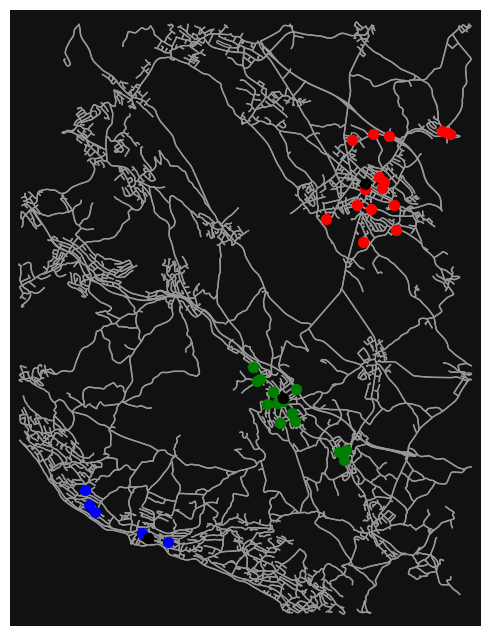

In [18]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox

def plot_graph_with_demand_and_man_stops(G, demand_points, man_stops):
    """
    Plots a graph with demand points and man stops.
    
    Parameters:
        - G (networkx.MultiDiGraph): The street network graph.
        - demand_points (list of int): List of node IDs representing demand points.
        - man_stops (list of int): List of node IDs representing man stops.
    """
    # Plot des Straßennetzwerks ohne Node-Größe
    fig, ax = ox.plot_graph(G, node_size=0, show=False)
    
    # Markiere Demand Points
    for i, node_id in enumerate(demand_points):
        node_position = G.nodes[node_id]['x'], G.nodes[node_id]['y']
        if i < 5:
            ax.scatter(*node_position, color='blue', s=50, zorder=5)  # Erste 5 Punkte blau
        elif i < 20:
            ax.scatter(*node_position, color='green', s=50, zorder=5)  # Nächste 15 Punkte grün
        else:
            ax.scatter(*node_position, color='red', s=50, zorder=5)  # Restliche Punkte rot
    
    # Markiere Man Stops
    for node_id in man_stops:
        node_position = G.nodes[node_id]['x'], G.nodes[node_id]['y']
        ax.scatter(*node_position, color='black', s=50, zorder=5)  # Man Stops in Schwarz
    
    # Anzeigen des Plots
    plt.show()

# Funktion aufrufen, um den Plot zu erstellen
plot_graph_with_demand_and_man_stops(G, sorted_demand_nodes, main_stop_nodes)


In [27]:
print(successful_trip_points)
print(successful_trip_routes)
print(type(successful_trip_points))
print(type(successful_trip_routes[0]))

[(66861087, 393962506), (393962506, 627939873), (627939873, 267951857), (267951857, 264890212)]
[[66861087, 2509340820, 35830597, 35830795, 35830692, 35830580, 35830685, 8486550706, 2312556487, 1630362967, 207713093, 207713019, 207713021, 218316046, 2503945386, 2504131256, 2504133278, 2503945464, 2511955657, 2511955641, 35831042, 2507646819, 206189293, 35831079, 206152111, 35831116, 1631987326, 35831136, 1599382670, 216320036, 393951118, 35831131, 35831160, 4083586892, 264890214, 216282009, 4083586928, 216282586, 216283486, 393962506], [393962506, 216283486, 216282586, 4083586928, 4083586933, 469833806, 469833850, 1880125007, 291902375, 291902959, 291902370, 35831193, 2459192571, 1599382891, 233039815, 265155506, 27505281, 27505280, 35831539, 27505267, 1479539363, 1479539463, 1479539522, 1479539549, 1479539559, 1628215936, 470238974, 104269687, 1391428831, 1901388432, 1901388406, 1901388421, 1901388429, 1628195659, 31107435, 1391428853, 1935897453, 316481992, 269549781, 101777363, 3708

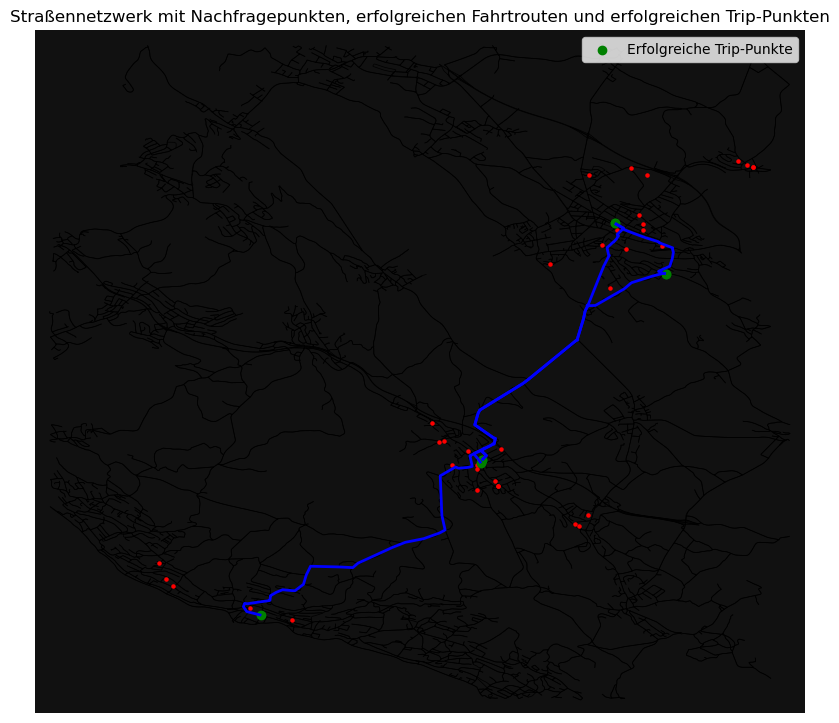

In [20]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import geopandas as gpd
from shapely.geometry import LineString, Point

def plot_street_network_with_demand_points_and_routes(graph, demand_gdf, successful_trip_routes, successful_trip_points):
    # Plot des Straßennetzwerks
    fig, ax = ox.plot_graph(graph, node_size=0, edge_color='k', edge_linewidth=0.5, show=False)

    # Plot der erfolgreichen Fahrtrouten
    for route in successful_trip_routes:
        route_nodes = [(graph.nodes[node]['x'], graph.nodes[node]['y']) for node in route]
        route_line = LineString(route_nodes)
        route_gdf = gpd.GeoDataFrame({'geometry': [route_line]})
        route_gdf.plot(ax=ax, linewidth=2, color='blue')

    # Plot der Nachfragepunkte
    demand_gdf.plot(ax=ax, color='red', markersize=5)

    # Plot der erfolgreichen Trip-Punkte als separate Marker
    successful_trip_nodes = [node for start, end in successful_trip_points for node in (start, end)]
    successful_trip_nodes_coords = [(graph.nodes[node]['x'], graph.nodes[node]['y']) for node in successful_trip_nodes]
    successful_trip_nodes_x, successful_trip_nodes_y = zip(*successful_trip_nodes_coords)
    ax.scatter(successful_trip_nodes_x, successful_trip_nodes_y, color='green', label='Erfolgreiche Trip-Punkte')

    plt.title('Straßennetzwerk mit Nachfragepunkten, erfolgreichen Fahrtrouten und erfolgreichen Trip-Punkten')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Beispielaufruf der aktualisierten Plot-Funktion
plot_street_network_with_demand_points_and_routes(G, demand_gdf_wgs84, successful_trip_routes, successful_trip_points)


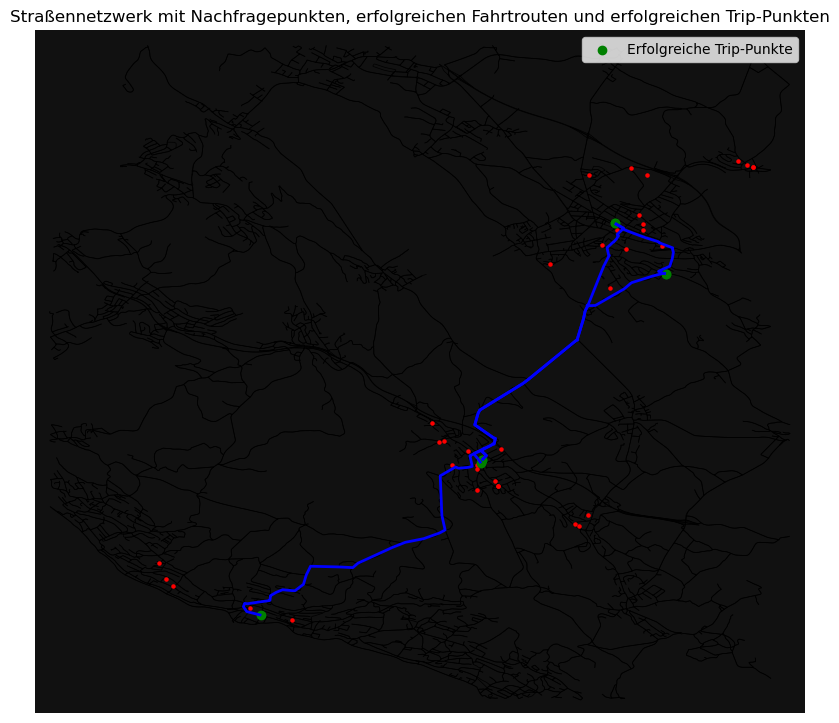

In [21]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import geopandas as gpd
from shapely.geometry import LineString, Point

def plot_street_network_with_demand_points_and_routes(graph, demand_gdf, successful_trip_routes, successful_trip_points):
    # Plot des Straßennetzwerks
    fig, ax = ox.plot_graph(graph, node_size=0, edge_color='k', edge_linewidth=0.5, show=False)

    # Plot der erfolgreichen Fahrtrouten
    for route in successful_trip_routes:
        route_nodes = [(graph.nodes[node]['x'], graph.nodes[node]['y']) for node in route]
        if len(route_nodes) >= 2:
            route_line = LineString(route_nodes)
            route_gdf = gpd.GeoDataFrame({'geometry': [route_line]})
            route_gdf.plot(ax=ax, linewidth=2, color='blue')

    # Plot der Nachfragepunkte
    demand_gdf.plot(ax=ax, color='red', markersize=5)

    # Plot der erfolgreichen Trip-Punkte als separate Marker
    successful_trip_nodes = [node for start, end in successful_trip_points for node in (start, end)]
    successful_trip_nodes_coords = [(graph.nodes[node]['x'], graph.nodes[node]['y']) for node in successful_trip_nodes]
    successful_trip_nodes_x, successful_trip_nodes_y = zip(*successful_trip_nodes_coords)
    ax.scatter(successful_trip_nodes_x, successful_trip_nodes_y, color='green', label='Erfolgreiche Trip-Punkte')

    plt.title('Straßennetzwerk mit Nachfragepunkten, erfolgreichen Fahrtrouten und erfolgreichen Trip-Punkten')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Beispielaufruf der aktualisierten Plot-Funktion
plot_street_network_with_demand_points_and_routes(G, demand_gdf_wgs84, successful_trip_routes, successful_trip_points)


In [ ]:
def process_demand_points(demand_nodes, target_nodes, main_stop_nodes, graph):
    successful_trips = 0
    successful_trip_points = []
    successful_trip_routes = []
    total_travel_time = 0
    max_travel_time_per_section = 600

    for index, row in demand_nodes.iterrows():
        demand_node = row['nearest_node']
        start_mainstop, ziel_mainstop = row['section']
        
        startpunkt_row = main_stop_nodes.loc[main_stop_nodes.index == start_mainstop]
        nearest_node_startpunkt = startpunkt_row['nearest_node'].values[0]
        zielpunkt_row = main_stop_nodes.loc[main_stop_nodes.index == ziel_mainstop]
        nearest_node_zielpunkt = zielpunkt_row['nearest_node'].values[0]
        
        travel_time_to_demandnode = calculate_travel_time(graph, nearest_node_startpunkt, demand_node)
        travel_time_to_next_mainnode = calculate_travel_time(graph, demand_node, nearest_node_zielpunkt)

        if max_travel_time_per_section > travel_time_to_demandnode + travel_time_to_next_mainnode:
            for index, row in target_nodes.iterrows():
                target_node = row['nearest_node']
                start_mainstop_dest, ziel_mainstop_dest = row['section']
                startpunkt_row_dest = main_stop_nodes.loc[main_stop_nodes.index == start_mainstop_dest]
                nearest_node_startpunkt_dest = startpunkt_row_dest['nearest_node'].values[0]
                zielpunkt_row_dest = main_stop_nodes.loc[main_stop_nodes.index == ziel_mainstop_dest]
                nearest_node_zielpunkt_dest = zielpunkt_row_dest['nearest_node'].values[0]
                
                travel_time_to_demandnode_dest = calculate_travel_time(graph, nearest_node_startpunkt_dest, target_node)
                travel_time_to_next_mainnode_dest = calculate_travel_time(graph, target_node, nearest_node_zielpunkt_dest)

                if max_travel_time_per_section > travel_time_to_demandnode_dest + travel_time_to_next_mainnode_dest:
                    successful_trips += 1
                    successful_trip_points.extend([demand_node, target_node])
                    successful_trip_routes.append(nx.shortest_path(graph, demand_node, nearest_node_startpunkt) + nx.shortest_path(graph, nearest_node_zielpunkt, demand_node))
                    successful_trip_routes.append(nx.shortest_path(graph, target_node, nearest_node_startpunkt_dest) + nx.shortest_path(graph, nearest_node_zielpunkt_dest, target_node))
                    total_travel_time += travel_time_to_demandnode + travel_time_to_next_mainnode + travel_time_to_demandnode_dest + travel_time_to_next_mainnode_dest

    return successful_trips, successful_trip_points, successful_trip_routes, total_travel_time

def get_nearest_node(G, point):
    nearest_node = ox.distance.nearest_nodes(G, point.x, point.y)
    return nearest_node

def find_nearest_point(graph, point):
    # Finde den nächsten Punkt im Straßennetzwerk zum gegebenen Punkt
    nearest_node = get_nearest_node(graph, point)
    return nearest_node

def calculate_travel_time(G, source, target_node):    
    # Berechne die Reisezeit zwischen den nächsten Netzwerkknoten
    travel_time = nx.shortest_path_length(G, source, target_node, weight='travel_time')
    return travel_time

# Beispielaufruf der Funktion
successful_trips, successful_trip_points, successful_trip_routes, total_travel_time = process_demand_points(demand_gdf, target_gdf, ODPT_stops_wgs84_gdf, G)



In [ ]:
def process_demand_points(demand_nodes, target_nodes, main_stop_nodes, main_stop_nodes_return, graph):
    successful_trips = 0
    successful_trip_points = []
    successful_trip_routes = []
    total_travel_time = 0
    max_travel_time_per_section = 900

    # Erstelle eine Liste mit den Abschnitts-Trip-Punkten
    section_trip_points = create_section_trip_points(main_stops_gdf)
    #print(section_trip_points)

    # Iteriere über alle Demand-Knoten
    for demand_index, demand_row in demand_nodes.iterrows():
        demand_node = demand_row['nearest_node']
        demand_start_stop, demand_end_stop = demand_row['section']
        
        # Suche den Start-Hauptknoten des Demand-Knotens
        demand_start_stop_row = main_stop_nodes.loc[main_stop_nodes.index == demand_start_stop]
        nearest_node_demand_start = demand_start_stop_row['nearest_node'].values[0]
        #print('Start mainstop' , nearest_node_demand_start)
        
        # Suche den Ziel-Hauptknoten des Demand-Knotens
        demand_end_stop_row = main_stop_nodes.loc[main_stop_nodes.index == demand_end_stop]
        nearest_node_demand_end = demand_end_stop_row['nearest_node'].values[0]
        #print('demand node', demand_node)

        # Sortiere den Demand-Knoten in die entsprechende Abschnittsliste ein
        #print('mainstop start', nearest_node_demand_start)
        #print(type(nearest_node_demand_start))
        #print('mainstop ziel',nearest_node_demand_end)
        print('section_trip_points 1', section_trip_points)
        section_list = sort_demand_node(demand_node, section_trip_points, nearest_node_demand_start, nearest_node_demand_end)
        #print('section of demand node', section_list)
        #print('section_trip_points 1', section_trip_points)

        section_travel_time = calculate_total_trip_time(graph, section_list)
        #print('section travel time', section_travel_time)

        # Überprüfe, ob die Section-Zeit größer als die maximale Reisezeit pro Abschnitt ist
        if section_travel_time > max_travel_time_per_section:
            # Entferne den Demand-Knoten aus der Liste der Abschnittspunkte
            #print('section_trip_points 2', section_trip_points)
            remove_node_from_section(demand_node, section_trip_points)
            #print('section_trip_points 3', section_trip_points)
            continue

        # Finde die zugehörigen Zielknoten für diesen Demand-Knoten
        corresponding_target_node = target_nodes.loc[target_nodes['passagier_nummer'] == demand_row['passagier_nummer']]
        #print('corresponding target node', corresponding_target_node)
        section_tuple = corresponding_target_node['section'].values[0]
        target_start_stop, target_end_stop = section_tuple
        target_node = corresponding_target_node['nearest_node'].values[0]

        # Suche den Start-Hauptknoten des Ziel-Knotens
        target_start_stop_row = main_stop_nodes.loc[main_stop_nodes.index == target_start_stop]
        nearest_node_target_start = target_start_stop_row['nearest_node'].values[0]
        #print('nearest_node_target_start', nearest_node_target_start)
        
        # Suche den Ziel-Hauptknoten des Ziel-Knotens
        target_end_stop_row = main_stop_nodes.loc[main_stop_nodes.index == target_end_stop]
        nearest_node_target_end = target_end_stop_row['nearest_node'].values[0]
        #print('nearest_node_target_end', nearest_node_target_end)


        #print('target_node', target_node)
        section_list_target = sort_demand_node(target_node, section_trip_points, nearest_node_target_start, nearest_node_target_end)
        #print('section of target node', section_list_target)

        section_travel_time_target = calculate_total_trip_time(graph, section_list_target)
        #print('section travel time target', section_travel_time_target)
        #print('section travel time target', section_travel_time_target)

        # Überprüfe, ob die Section-Zeit bis zum Zielknoten größer als die maximale Reisezeit pro Abschnitt ist
        if section_travel_time_target > max_travel_time_per_section:
            # Entferne den Demand-Knoten aus der Liste der Abschnittspunkte
            section_trip_points = remove_target_node_from_list(section_list_target, target_node)
            continue
        
        # Die Route zwischen Hauptknoten liegt innerhalb der Zeitbeschränkung
        successful_trips += 1

    # Route alle sections
    print(section_trip_points)


    return successful_trips, successful_trip_points, successful_trip_routes, total_travel_time



def get_nearest_node(G, point):
    nearest_node = ox.distance.nearest_nodes(G, point.x, point.y)
    return nearest_node

def find_nearest_point(graph, point):
    # Finde den nächsten Punkt im Straßennetzwerk zum gegebenen Punkt
    nearest_node = get_nearest_node(graph, point)
    return nearest_node

def calculate_travel_time(G, source, target_node):    
    # Berechne die Reisezeit zwischen den nächsten Netzwerkknoten
    travel_time = nx.shortest_path_length(G, source, target_node, weight='travel_time')
    return travel_time

def create_section_trip_points(df):
    section_points_lists = []
    prev_nearest_node = None

    for index, row in df.iterrows():
        current_nearest_node = row['nearest_node']
        if prev_nearest_node is not None:
            section_points_lists.append([prev_nearest_node, current_nearest_node])
        prev_nearest_node = current_nearest_node

    return section_points_lists

def sort_demand_node(demand_node, section_trip_points, nearest_node_demand_start, nearest_node_demand_end):
    # Initialisiere die Variable für den Abschnittsindex
    section_index = None
    
    # Durchlaufe jede Abschnittsliste, um herauszufinden, in welchem Abschnitt sich die Start- und Endknoten befinden
    for i, section_points in enumerate(section_trip_points):
        # Überprüfe, ob nearest_node_demand_start und nearest_node_demand_end in der Abschnittsliste vorkommen
        print('section points', section_points)
        print('nearest_node_demand_start', nearest_node_demand_start)
        if nearest_node_demand_start in section_points and nearest_node_demand_end in section_points:    
            section_index = i
            break
    
    # Wenn der Abschnittsindex gefunden wurde, füge den Demand-Knoten in die entsprechende Abschnittsliste ein
    if section_index is not None:
        section_trip_points[section_index].insert(-1, demand_node)
    
    # Gebe die Liste zurück, in der sich der Demand-Knoten befindet, oder eine leere Liste, wenn kein passender Abschnitt gefunden wurde
    return section_trip_points[section_index] if section_index is not None else []



def calculate_total_trip_time(graph, section_points_list):
    total_trip_time = 0

    # Iteriere über alle Paare von Knoten in der Abschnittsliste
    for i in range(len(section_points_list) - 1):
        source_node = section_points_list[i]
        target_node = section_points_list[i + 1]

        # Berechne die Reisezeit zwischen den Knoten und addiere sie zur Gesamtzeit hinzu
        trip_time = nx.shortest_path_length(graph, source_node, target_node, weight='travel_time')
        total_trip_time += trip_time

    return total_trip_time

def remove_node_from_section(node, section_trip_points):
    for section in section_trip_points:
        if node in section:
            section.remove(node)
            break


def remove_target_node_from_list(node_list, target_node):
    updated_node_list = [node for node in node_list if node != target_node]
    return updated_node_list

# Beispielaufruf der Funktion
successful_trips, successful_trip_points, successful_trip_routes, total_travel_time = process_demand_points(demand_gdf, target_gdf, ODPT_stops_wgs84_gdf, main_stops_gdf, G)



In [ ]:
# Berechne den kürzesten Weg zwischen dem Demand-Knoten und dem nächsten Hauptknoten
        #shortest_path_demand_main = nx.shortest_path(graph, demand_node, start_stop, weight='travel_time')

        # Überprüfe, ob der Destination-Knoten im ersten Abschnitt liegt

            # Wenn ja, berechne den kürzesten Weg zwischen dem Demand-Knoten und dem Destination-Knoten
            # und den kürzesten Weg zwischen dem Destination-Knoten und dem nächsten Hauptknoten
            # und überprüfe ob die Summe der Reisezeit der beiden Wege,
            # kleiner ist als die vorgegebene Reisezeit
                # Wenn ja, füge den Demand-Knoten zur Liste der erfolgreichen Fahrten hinzu
                # und erhöhe den Zähler für erfolgreiche Fahrten
                # und speichere die Route und die Punkte der erfolgreichen Fahrt
                # und erhöhe die Gesamtreisezeit
                # Wenn nein, fahre zum nächsten Demand-Knoten fort

            # Wenn nein, berechne den kürzesten Weg zwischen dem Destination-Knoten, 
            # dem nächsten Hauptknoten und zum übernächsten Hauptknoten
            # und überprüfe ob die Summe der Reisezeit der beiden Wege,
            # kleiner ist als die vorgegebene Reisezeit
                # Wenn ja, füge den Demand-Knoten zur Liste der erfolgreichen Fahrten hinzu
                # und erhöhe den Zähler für erfolgreiche Fahrten
                # und speichere die Route und die Punkte der erfolgreichen Fahrt
                # und erhöhe die extra Gesamtreisezeit
                # und speichere den extra Trip Stop in der Liste extra_trip_stop
                # Wenn nein, fahre zum nächsten Demand-Knoten fort

In [ ]:
# impute edge (driving) speeds and calculate edge travel times
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

# you can convert MultiDiGraph to/from GeoPandas GeoDataFrames
print(type(G))
gdf_nodes, gdf_edges = ox.utils_graph.graph_to_gdfs(G)
G = ox.utils_graph.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

# convert MultiDiGraph to DiGraph to use nx.betweenness_centrality function
# choose between parallel edges by minimizing travel_time attribute value
D = ox.utils_graph.get_digraph(G, weight="travel_time")

# calculate node betweenness centrality, weighted by travel time
bc = nx.betweenness_centrality(D, weight="travel_time", normalized=True)
nx.set_node_attributes(G, values=bc, name="bc")

# plot the graph, coloring nodes by betweenness centrality
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")
fig, ax = ox.plot.plot_graph(
    G, bgcolor="k", node_color=nc, node_size=50, edge_linewidth=2, edge_color="#333333")